In [1]:
import pandas as pd
loan=pd.read_csv('../.Database/merged_cleaned_loan.csv')
pd.set_option('display.max_columns', None)

In [2]:
# Drop non-numerical columns from X
X=loan.drop(columns=['addr_state','emp_title','loan_status','issue_d','issue_y','issue_m','title'])

# Drop annual_inc, to use log_annual_inc
X=X.drop(columns=['annual_inc'])

# Drop outcome variables from X
X=X.drop(columns=['loan_status_grouped','grade','sub_grade', 'int_rate'])

# Select outcome variable for Y
y=loan['loan_status_grouped']

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score

In [5]:
#Separate numerical and categorical columns
categorical_columns = ['home_ownership', 'term','purpose','emp_length']
numerical_columns = X.select_dtypes(include=['float64']).columns

# Apply OneHotEncoding to categorical columns before splitting
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Now perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Ensure the train and test sets have the same structure (dummies already handled)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Apply scaling to numerical columns
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [10]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import metrics

model = keras.Sequential([
    layers.Dense(25, activation='relu', kernel_initializer='he_normal'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax') 

])

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # for label encoding, transform it to one
              metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.7834 - loss: 0.5287 - val_accuracy: 0.7882 - val_loss: 0.4862
Epoch 2/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.7844 - loss: 0.4888 - val_accuracy: 0.7884 - val_loss: 0.4833
Epoch 3/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.7857 - loss: 0.4849 - val_accuracy: 0.7870 - val_loss: 0.4830
Epoch 4/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.7862 - loss: 0.4842 - val_accuracy: 0.7871 - val_loss: 0.4826
Epoch 5/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.7861 - loss: 0.4844 - val_accuracy: 0.7885 - val_loss: 0.4829
Epoch 6/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.7844 - loss: 0.4856 - val_accuracy: 0.7873 - val_loss: 0.4823
Epoch 7/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.7861 - loss: 0.4819 - val_accuracy: 0.7882 - val_loss: 0.4823
Epoch 8/10
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.7870 - loss: 0

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

1612/1612 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7856 - loss: 0.4848
Test accuracy: 0.7848941087722778


1612/1612 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
              precision    recall  f1-score   support

         0.0       0.79      0.99      0.88     40328
         1.0       0.58      0.05      0.09     11228

    accuracy                           0.78     51556
   macro avg       0.68      0.52      0.48     51556
weighted avg       0.74      0.78      0.71     51556



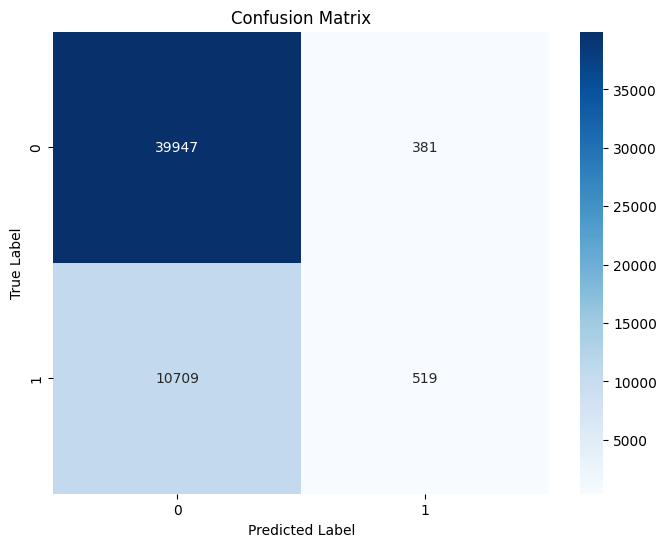

In [39]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Create classification report
print(classification_report(y_test, y_pred_classes))

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

xgb = XGBClassifier(
    n_estimators=500,        # Number of boosting rounds
    learning_rate=0.1,       # Step size shrinkage to prevent overfitting
    max_depth=3,             # Maximum depth of a tree
    subsample=0.8,           # Subsample ratio of the training data
    colsample_bytree=0.8,    # Subsample ratio of features for each tree
    gamma=0,                 # Minimum loss reduction required to make a further partition
    reg_lambda=1,            # L2 regularization term
    objective='binary:logistic' # For multiclass classification (use 'binary:logistic' for binary)
)

In [ ]:
# XG-boost
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

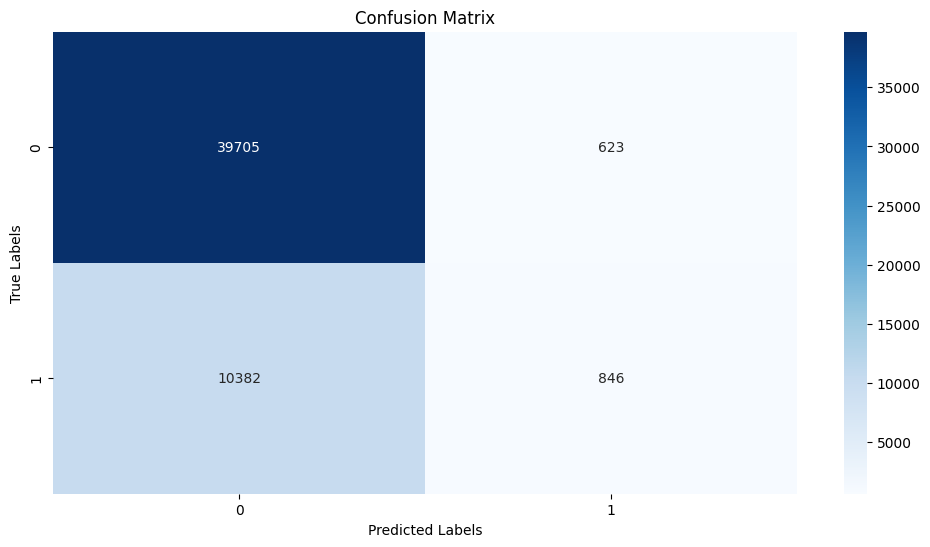

              precision    recall  f1-score   support

         0.0       0.79      0.98      0.88     40328
         1.0       0.58      0.08      0.13     11228

    accuracy                           0.79     51556
   macro avg       0.68      0.53      0.51     51556
weighted avg       0.75      0.79      0.72     51556

Accuracy Test: 0.7865427884242377
F1 Score Test: 0.716030280117661


In [28]:
y_pred_test_xgb = xgb.predict(X_test)

cm = confusion_matrix(y_test, y_pred_test_xgb)

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 6))  # Set the figure size
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', cbar=True, xticklabels=['0', '1'], yticklabels=['0', '1'])

# Add titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(classification_report(y_test, y_pred_test_xgb))

Accuracy_Test = accuracy_score(y_test, y_pred_test_xgb)
F1_Score_Test = f1_score(y_test, y_pred_test_xgb, average='weighted')

print(f"Accuracy Test: {Accuracy_Test}")
print(f"F1 Score Test: {F1_Score_Test}")

In [ ]:
# Random forest classifier (without PCA)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
rf_classifier = RandomForestClassifier(n_estimators=500,  max_depth=7, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, n_estimators=500, random_state=42)

In [35]:
y_pred_test = rf_classifier.predict(X_test)

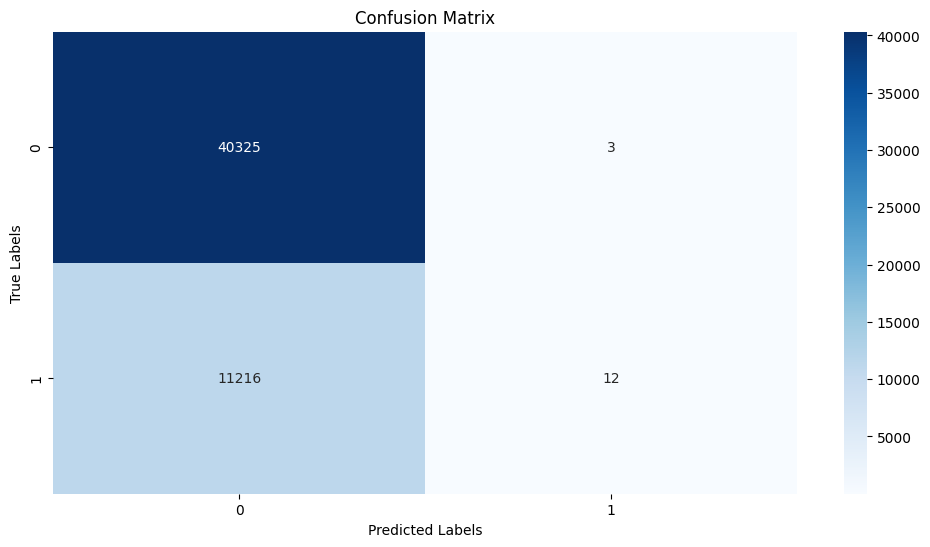

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 6))  # Set the figure size
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', cbar=True, xticklabels=['0', '1'], yticklabels=['0', '1'])

# Add titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [38]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88     40328
         1.0       0.80      0.00      0.00     11228

    accuracy                           0.78     51556
   macro avg       0.79      0.50      0.44     51556
weighted avg       0.79      0.78      0.69     51556

